In [19]:
import pandas as pd
import os
import csv
import logging
import joblib
import streamlit as st
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

st.set_page_config(page_title='Определение языка текста', layout='centered')

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

directory = "C:/Users/pillya/Documents/ish/vkr/datasets"
model_path = 'language_classifier.pkl'
vectorizer_path = 'tfidf_vectorizer.pkl'

def convert_tsv_to_csv(directory):
    for filename in os.listdir(directory):
        if filename.endswith('.tsv'):
            tsv_file = os.path.join(directory, filename)
            csv_file = os.path.join(directory, filename.replace('.tsv', '.csv'))
            try:
                with open(tsv_file, 'r', newline='', encoding='utf-8') as infile, open(csv_file, 'w', newline='', encoding='utf-8') as outfile:
                    reader = csv.reader(infile, delimiter='\t')
                    writer = csv.writer(outfile)
                    for row in reader:
                        writer.writerow(row)
                logging.info(f'Converted {tsv_file} to {csv_file}')
            except Exception as e:
                logging.error(f"Error converting {tsv_file}: {e}")

def process_csv_files(directory):
    for filename in os.listdir(directory):
        if filename.endswith('.csv'):
            file_path = os.path.join(directory, filename)
            try:
                df = pd.read_csv(file_path, header=None)
                df.columns = ['text', 'value']
                df.to_csv(file_path, index=False)
                logging.info(f'Successfully processed and overwritten {filename}')
            except PermissionError as e:
                logging.error(f"Permission error for {filename}: {e}")
            except FileNotFoundError as e:
                logging.error(f"File not found: {e}")
            except Exception as e:
                logging.error(f"An error occurred while processing {filename}: {e}")

2025-05-02 19:57:23.061 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


2025-05-02 19:57:23,129 - INFO - Converted C:/Users/pillya/Documents/ish/vkr/datasets\ger.tsv to C:/Users/pillya/Documents/ish/vkr/datasets\ger.csv
2025-05-02 19:57:23,152 - INFO - Converted C:/Users/pillya/Documents/ish/vkr/datasets\gre.tsv to C:/Users/pillya/Documents/ish/vkr/datasets\gre.csv
2025-05-02 19:57:23,171 - INFO - Converted C:/Users/pillya/Documents/ish/vkr/datasets\rus.tsv to C:/Users/pillya/Documents/ish/vkr/datasets\rus.csv
2025-05-02 19:57:23,185 - INFO - Converted C:/Users/pillya/Documents/ish/vkr/datasets\tur.tsv to C:/Users/pillya/Documents/ish/vkr/datasets\tur.csv
2025-05-02 19:57:23,230 - INFO - Successfully processed and overwritten ger.csv
2025-05-02 19:57:23,267 - INFO - Successfully processed and overwritten gre.csv
2025-05-02 19:57:23,288 - INFO - Successfully processed and overwritten rus.csv
2025-05-02 19:57:23,307 - INFO - Successfully processed and overwritten tur.csv
2025-05-02 19:57:23,405 - INFO - Очистка прошла успешно C:/Users/pillya/Documents/ish/vk

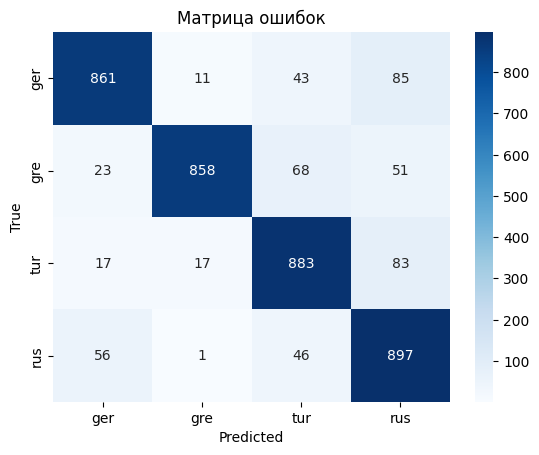

Введите несколько слов на любом языке, и модель предскажет язык:


2025-05-02 19:57:49,090 - INFO -   language            text  value
0      ger  Servicepartner      O
1      ger          Moment      O
2      ger            Satz  I-LAW
3      ger             von      O
4      ger           nehme      O
5      ger      lückenhaft      O
6      ger            dass      O
7      ger   tatsächlichen      O
8      ger             der      O
9      ger        gleichen      O
2025-05-02 19:57:49,092 - INFO - language
ger    5000
gre    5000
tur    5000
rus    5000
Name: count, dtype: int64
2025-05-02 19:57:49,093 - INFO - [[0. 0. 0. ... 0. 0. 0.]]


Предсказанный язык: rus
Топ n-грамм для русского языка:
о
,
и
в
а
е
н
с
.
т
р
л
к
д
м
п
у
я
б
на


2025-05-02 19:57:49,917 - INFO -               precision    recall  f1-score   support

         ger       0.90      0.86      0.88      1000
         gre       0.97      0.86      0.91      1000
         rus       0.85      0.88      0.87      1000
         tur       0.80      0.90      0.85      1000

    accuracy                           0.87      4000
   macro avg       0.88      0.87      0.88      4000
weighted avg       0.88      0.87      0.88      4000

2025-05-02 19:57:49,919 - INFO - Text: başına
True Language: tur
Predicted Language: tur

2025-05-02 19:57:49,921 - INFO - Text: 3
True Language: ger
Predicted Language: ger

2025-05-02 19:57:49,923 - INFO - Text: Турецкой
True Language: rus
Predicted Language: rus

2025-05-02 19:57:49,925 - INFO - Text: fünf
True Language: ger
Predicted Language: ger

2025-05-02 19:57:49,927 - INFO - Text: όσοι
True Language: gre
Predicted Language: gre

2025-05-02 19:57:49,929 - INFO - Предсказанный язык: rus


In [20]:
def load_dataset(file_path):
    return pd.read_csv(file_path)

def clean_dataset(df):
    df = df.dropna(subset=['text', 'value'])
    df = df[df['text'].str.strip() != '']
    df = df[df['value'].str.strip() != '']
    df = df[df['text'].apply(lambda x: all(c.isprintable() for c in x))]
    df = df[df['value'].apply(lambda x: all(c.isprintable() for c in x))]
    return df

def load_and_clean_datasets(directory, languages):
    datasets = []
    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(load_and_clean_dataset, directory, lang) for lang in languages]
        for future in futures:
            df = future.result()
            if df is not None:
                datasets.append(df)
    return datasets

def load_and_clean_dataset(directory, lang):
    file_path = os.path.join(directory, f'{lang}.csv')
    try:
        df = load_dataset(file_path)
        df = clean_dataset(df)
        df = df.sample(n=min(5000, len(df)), random_state=42)   #Ограничение
        logging.info(f'Очистка прошла успешно {file_path} (строк после сэмплирования: {len(df)})')
        return df
    except PermissionError as e:
        logging.error(f"Permission error: {e}")
    except FileNotFoundError as e:
        logging.error(f"File not found: {e}")
    except Exception as e:
        logging.error(f"An error occurred: {e}")
    return None

def main():
    convert_tsv_to_csv(directory)
    process_csv_files(directory)

    languages = ['ger', 'gre', 'tur', 'rus']
    datasets = load_and_clean_datasets(directory, languages)

    combined_df = pd.concat(datasets, keys=languages, names=['language', 'index'])
    combined_df = combined_df.reset_index(level=1, drop=True).reset_index()

    train_df, test_df = train_test_split(combined_df, test_size=0.2, random_state=42, stratify=combined_df['language'])

    if '1.' in train_df.columns:
        train_df.rename(columns={'1.': 'text'}, inplace=True)
    if '1.' in test_df.columns:
        test_df.rename(columns={'1.': 'text'}, inplace=True)
    if 'text' not in train_df.columns:
        raise KeyError("Столбец 'text' не найден в train_df")
    if 'text' not in test_df.columns:
        raise KeyError("Столбец 'text' не найден в test_df")

    logging.info("Баланс классов в обучающем наборе:")
    logging.info(train_df['language'].value_counts())

    vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(1, 4), max_features=5000)
    X_train = vectorizer.fit_transform(train_df['text'].dropna())
    X_test = vectorizer.transform(test_df['text'].dropna())
    y_train = train_df['language']
    y_test = test_df['language']
    logging.info("Векторизация с символьными n-граммами выполнена успешно")

    model = VotingClassifier(estimators=[
        ('lr', LogisticRegression(max_iter=1000)),
        ('svc', SVC(probability=True)),
        ('nb', MultinomialNB())
    ], voting='soft')

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    logging.info(classification_report(y_test, y_pred))

    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=languages, yticklabels=languages)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Матрица ошибок')
    plt.show()

    joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')
    joblib.dump(model, 'language_classifier.pkl')

    #vectorizer = joblib.load('tfidf_vectorizer.pkl')
    #model = joblib.load('language_classifier.pkl')
    
    def predict_language(text):
        text_vectorized = vectorizer.transform([text])
        predicted_language = model.predict(text_vectorized)[0]
        return predicted_language

    print("Введите несколько слов на любом языке, и модель предскажет язык:")
    user_input = input("Ввод: ")
    predicted_language = predict_language(user_input)
    print(f"Предсказанный язык: {predicted_language}")

    features = vectorizer.get_feature_names_out()
    rus_texts = train_df[train_df['language'] == 'rus']['text']
    rus_vectorized = vectorizer.transform(rus_texts)
    mean_tfidf = rus_vectorized.mean(axis=0).A1
    top_indices = mean_tfidf.argsort()[-20:][::-1]
    print("Топ n-грамм для русского языка:")
    for i in top_indices:
        print(features[i])

    # Проверка данных
    logging.info(combined_df.head(10))
    logging.info(combined_df['language'].value_counts())
    sample_text = "Доброе утро"
    sample_vectorized = vectorizer.transform([sample_text])
    logging.info(sample_vectorized.toarray())
    y_pred = model.predict(X_test)
    logging.info(classification_report(y_test, y_pred))
    for i in range(5):
        sample_text = test_df['text'].iloc[i]
        sample_vectorized = vectorizer.transform([sample_text])
        predicted_language = model.predict(sample_vectorized)[0]
        true_language = test_df['language'].iloc[i]
        logging.info(f"Text: {sample_text}\nTrue Language: {true_language}\nPredicted Language: {predicted_language}\n")

    user_input = "Россия"
    predicted_language = predict_language(user_input)
    logging.info(f"Предсказанный язык: {predicted_language}")

if __name__ == "__main__":
    main()